In [1]:
import torch
import yaml
import einops
import torchvision
import os
from tqdm import tqdm
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms.functional import to_pil_image
import torch.nn.functional as F
import umap.umap_ as umap
from utils import make_coord_grid
import yaml
from datasets import make as make_dataset
from models import make as make_model
import pickle
from sklearn.manifold import TSNE
import os
from glob import glob
import ipywidgets as widgets
from ipywidgets import interact_manual
import matplotlib.pyplot as plt
import numpy as np
import monai.transforms as monai_t
from datasets.fmri_dataloader import DataModule

def load_config(yaml_path):
    with open(yaml_path, 'r') as f:
        return yaml.safe_load(f)

def resize_sequence(seq, resize):
        B, C, H, W, D, T = seq.shape
        spatial_size = [resize,  resize, resize]
        resized_shape = [B, C] + spatial_size + [T]
        resize_transform = monai_t.Resize(spatial_size=(spatial_size))
        seq = einops.rearrange(seq, 'b c h w d t -> b t c h w d')
        seq_resized = torch.zeros(resized_shape).to(seq.device)
        for b in range(B):
            for t in range(T):
                seq_resized[b, :, :, :, :, t] = resize_transform(seq[b, t, :, :, :, :])
        del seq
        print(seq_resized.shape)
        return seq_resized
    
@torch.no_grad()
def evaluate_model(model, dataloader, device='cuda', res_factor = 1, lainr = True, only_one=False, sr = True):
    model.eval()
    total_loss = 0
    total_psnr = 0
    count = 0
    i = 0

    for data in tqdm(dataloader, desc='Evaluating'):
        if i > 0 and only_one:
            break

        data = {k: (v.cuda() if isinstance(v, torch.Tensor) else v) for k, v in data.items()}

        '''for k, v in data.items():
            if torch.is_tensor(v):
                data[k] = v.cuda()'''
        #gt = data.pop('gt')
        gt_full = data.pop('fmri_sequence')
        resize = 48
        gt_full = resize_sequence(gt_full, resize)
        #print(f'gt_full shape is {gt_full.shape}')
        
        B = gt_full.shape[0]
        coord = make_coord_grid(gt_full.shape[-4:], (0, 1), device=gt_full.device)
        #print(coord.shape)
        coord = einops.repeat(coord, 'z h w t d -> b z h w t d', b=B)
        coord = coord[:, :, :, 24:25, 0:1, :] #(1, 1, H, W, 1, C)
        coord_flat = coord.view(B, -1, coord.shape[-1])  # (B, N, dim), N=Z*H*W*T
        #print(gt_full.shape)

        B, C, D, H, W, T = gt_full.shape
       
        pred = model(gt_full, coord_flat)
        gt_full = einops.rearrange(gt_full, 'b c z h w t -> b z h w t c')
        pred = pred.view(B, D, H, 1, 1, C)
        pred2 = pred.squeeze(3)
        pred2 = pred2.squeeze(3)[0]
        pred2 = einops.rearrange(pred2, 'h w c -> c h w')  

        #print(pred2.shape)
        #print(pred2[:, 0:15, 0:15])

        #print("pred", pred.shape, "gt slice", gt_full[0:1, 48:49, :, :, 0:1, :].shape)
        mses = ((pred - gt_full[: , :, :, 24:25, 0:1, :])**2).view(1, -1).mean(dim=-1)
        loss = mses.mean()
        psnr = (-10 * torch.log10(mses)).mean()

        total_loss += loss.item() * B
        total_psnr += psnr.item() * B
        count += B
        i+=1

    avg_loss = total_loss / count
    avg_psnr = total_psnr / count
    print(f"Avg Loss: {avg_loss:.6f}, Avg PSNR: {avg_psnr:.2f}")
    return avg_loss, avg_psnr


@torch.no_grad()
def visualize_results(model, dataloader, device='cuda', n_samples=8, out_dir='./eval_vis', figsize=(6, 3), res_factor = 1, lainr=True, sr = True):
    os.makedirs(out_dir, exist_ok=True)
    model.eval()
    data_iter = iter(dataloader)

    for i in range(n_samples):
        try:
            data = next(data_iter)
        except StopIteration:
            break

        data = {k: (v.cuda() if isinstance(v, torch.Tensor) else v) for k, v in data.items()}

        '''for k, v in data.items():
            if torch.is_tensor(v):
                data[k] = v.cuda()'''
        #gt = data.pop('gt')
        gt_full = data.pop('fmri_sequence')
        resize = 48
        gt_full = resize_sequence(gt_full, resize)
        B = gt_full.shape[0]
        coord = make_coord_grid(gt_full.shape[-4:], (0, 1), device=gt_full.device)
        coord = einops.repeat(coord, 'z h w t d -> b z h w t d', b=B)
        #coord_full = coord.view(B, -1, coord.shape[-1])
        coord = coord[:, :, :, 24:25, :, :] #(1, 1, H, W, 1, C)
        print(coord.shape)
        #coord_flat = coord.view(B, -1, coord.shape[-1])  # (B, N, dim), N=Z*H*W*T
        coord_flat = coord.reshape(B, -1, coord.shape[-1])
        print(coord_flat.shape[1])
        print(gt_full.shape)

        B, C, D, H, W, T = gt_full.shape
       
        pred = model(gt_full, coord_flat)
        #pred3 = model(gt_full, coord_full)
        #pred3 = pred3.view(B, D, H, W, T, C)
        
        gt_full = einops.rearrange(gt_full, 'b c z h w t -> b z h w t c')
        pred = pred.view(B, D, H, 1, T, C)
        pred2 = pred.squeeze(3)
        pred2 = pred2[0]
        pred = einops.rearrange(pred2, 'h w t c -> c h w t')
        pred = torch.clamp(pred, 0.0, 1.0)
        print(pred.max())
        print(pred.min())

        #pred = einops.rearrange(pred, 'h w c -> c h w')  # (C, H, W)

        # Convert tensors to NumPy for plotting
        gt = gt_full[:, :, :, 24:25, :, :]
        gt = gt.squeeze(3)
        gt = gt[0]
        gt = einops.rearrange(gt, 'h w t c -> c h w t')
        print(gt.max())
        print(gt.min())

        mses = ((pred - gt)**2).view(1, -1).mean(dim=-1)
        loss = mses.mean()
        psnr = (-10 * torch.log10(mses)).mean()
        print(psnr)
        # clamp values to [0, 1] range
        for i in range(1):
            gt_np = gt[:, :, :, i].cpu().numpy()
            pred_np = pred[:, :, :, i].cpu().numpy()
            
            # If your images are single-channel, squeeze channel dim
            if gt_np.shape[0] == 1:
                gt_np = gt_np.squeeze(0)
                pred_np = pred_np.squeeze(0)
            
            vmin, vmax = 0.0, 1.0  # fixed scale for both
            
            fig, axes = plt.subplots(1, 2, figsize=(8, 4))
            
            # Plot images
            im0 = axes[0].imshow(gt_np, vmin=vmin, vmax=vmax, cmap='viridis')
            axes[0].set_title('Ground Truth')
            axes[0].axis('off')
            
            im1 = axes[1].imshow(pred_np, vmin=vmin, vmax=vmax, cmap='viridis')
            axes[1].set_title('Prediction')
            axes[1].axis('off')
            
            # Create one colorbar to the far right
            cbar = fig.colorbar(im0, ax=axes, shrink=0.8, pad=0.05)
            cbar.ax.tick_params(labelsize=8)
            
            #plt.tight_layout()
            plt.show()
        #return pred3
        # plt.savefig(f"{out_dir}/comparison_{i}.png")
        # plt.close(fig)

        #plt.savefig(f"{out_dir}/comparison_{i}.png")
        #plt.close(fig)

    
@torch.no_grad()
def get_volume(model, dataloader, device='cuda', n_samples=8, out_dir='./eval_vis', figsize=(6, 3), res_factor = 1, lainr=True, sr = True):
    os.makedirs(out_dir, exist_ok=True)
    model.eval()
    data_iter = iter(dataloader)

    for i in range(n_samples):
        try:
            data = next(data_iter)
        except StopIteration:
            break

        data = {k: (v.cuda() if isinstance(v, torch.Tensor) else v) for k, v in data.items()}     
        gt_full = data.pop('fmri_sequence')
        resize = 24
        gt_full = resize_sequence(gt_full, resize)
        B = gt_full.shape[0]
        coord = make_coord_grid(gt_full.shape[-4:], (0, 1), device=gt_full.device)
        coord = einops.repeat(coord, 'z h w t d -> b z h w t d', b=B)
        coord_full = coord.view(B, -1, coord.shape[-1])
        print(gt_full.shape)

        B, C, D, H, W, T = gt_full.shape
        pred3 = model(gt_full, coord_full)
        pred3 = pred3.view(B, D, H, W, T, C)
        
        gt_full = einops.rearrange(gt_full, 'b c z h w t -> b z h w t c')
        return pred3

def set_lp_idxs(seq_len, num_lp, type = 'equidistant', n = 1):
        total_len = seq_len + num_lp
        if type == 'equidistant':
            insert_idxs = torch.linspace(0, total_len - 1, steps=num_lp).long()
        elif type == 'middle':
            insert_idxs = (np.array(range(num_lp))+(seq_len//2)).tolist()
            insert_idxs = torch.tensor(insert_idxs)
        elif type == 'n_group':
            if num_lp%n != 0:
                raise Exception("n must divide number of lps evenly")
            insert_idxs = []
            pre_idxs = torch.linspace(0, total_len - n, steps=num_lp//n).long()
            for idx in pre_idxs:
                insert_idxs.extend([idx+i for i in range(n)])
        return insert_idxs


In [5]:
data_module = DataModule('./cfgs/hcp_data_all_config.yaml')
data_module.setup()
train_loader = data_module.train_dataloader()
test_loader = data_module.val_dataloader()

Loading cached subject dictionary from data/subj_dict/S1200_age_HCP_filtered_run1_MNI_to_TRs.pickle
Loading splits from ./data/splits/S1200_split2.pkl
Randomly sampling 400 of 863 subjects.
Generating dataset list from scratch...
Number of subjects for S1200 'train': 400
Randomly sampling 50 of 107 subjects.
Loading cached dataset list from data/data_tuple/age_HCP_filtered_run1_MNI_to_TRs_val_seqlen2_within1_between1.0.csv
Cache is stale (subject mismatch). Regenerating...
Generating dataset list from scratch...
Number of subjects for S1200 'val': 50
Randomly sampling 50 of 109 subjects.
Loading cached dataset list from data/data_tuple/age_HCP_filtered_run1_MNI_to_TRs_test_seqlen2_within1_between1.0.csv
Cache is stale (subject mismatch). Regenerating...
Generating dataset list from scratch...
Number of subjects for S1200 'test': 50

Total training segments: 4800
Total validation segments: 600
Total test segments: 600


In [6]:
# Load YAML config
#cfg_string = 'imgrec_cifar10_mamba_lainr_fourier_long_constant'
#cfg_string = 'imgrec_celeba_transinr'
cfg_string = 'fmri_hcp_small_patch_resizelr_min20_hfmv_resume2'
#cfg_dataset_string = 'imgrec_cifar10_mamba_lainr_fourier_sr2'
cfg = load_config(f'./cfgs/{cfg_string}.yaml')
#cfg_dataset = load_config(f'./cfgs/poster_graphs/sr_comparison/{cfg_dataset_string}.yaml')
print(cfg)
#cfg['test_dataset'] = cfg_dataset['test_dataset']
#cfg_dt = cfg
#cfg_dt['model']['name'] = cfg['model']['name']+'_print_dt'
#cfg_dt['model']['args']['mamba_encoder']['name']= 'mamba_encoder_dt'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

FileNotFoundError: [Errno 2] No such file or directory: './cfgs/fmri_hcp_small_patch_resizelr_min20_hfmv_resume2.yaml'

In [10]:
#cfg['model']['args']['tokenizer']['name']= 'mamba_patch_tokenizer'
#cfg_dt['model']['args']['tokenizer']['name']= 'mamba_patch_tokenizer'
model = make_model(cfg['model']).to(device)
#model_dt = make_model(cfg_dt['model']).to(device)

torch.Size([1, 24, 24, 24, 1, 512])
13824


In [34]:
# Load checkpoint
#cfg_string_train = 'imgrec_cifar10_mamba_composers_fourier_long'
cfg_string_train = cfg_string
#cfg_string_train_full = f'{cfg_string_train}'
#cfg_train = load_config(f'./cfgs/sr_ablation/{cfg_string_train_full}.yaml')
ckpt_path = f'./save/{cfg_string_train}/epoch-last.pth'
checkpoint = torch.load(ckpt_path, weights_only=False)
print(checkpoint['model'].keys())
#model = torch.load(ckpt_path)['model']
model.load_state_dict(checkpoint['model']['sd'])
#model_dt.load_state_dict(checkpoint['model']['sd'])

dict_keys(['name', 'args', 'sd'])


<All keys matched successfully>

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def get_models(cfg_strings):
    models = []
    for cfg_string_name, cfg_string in cfg_strings:
        cfg = load_config(f'./cfgs/NIPS_4D_table/{cfg_string}.yaml')
        #rint(cfg)
        model = make_model(cfg['model']).to(device)
        ckpt_path = f'./save/{cfg_string}/epoch-last.pth'
        checkpoint = torch.load(ckpt_path, weights_only=False)
        #print(checkpoint['model'].keys())
        model.load_state_dict(checkpoint['model']['sd'])
        models.append((cfg_string_name, model))
    return models

strings = [('Mamba-GINR sp = 2', 'fmri_hcp_small_patch_resizelr_min20_hfmv_resume2'), ('Mamba-GINR sp = 4', 'fmri_hcp_medium_patch_propLT_min20_hfmv_resume'), ('LAGINR sp = 4', 'fmri_hcp_medium_patch_resizelr_min10_hfmv_lainr'), ('TransINR sp = 4', 'fmri_hcp_medium_patch_48_min20_hfmv_transinr')]
models = get_models(strings)

torch.Size([1, 24, 24, 24, 1, 512])
13824
torch.Size([1, 12, 12, 12, 1, 512])
1728


In [238]:
evaluate_model(model, train_loader, device, res_factor = 1, only_one=True, lainr=True, sr = True)

Evaluating:   0%|          | 0/2400 [00:00<?, ?it/s]

torch.Size([2, 1, 48, 48, 48, 2])


Evaluating:   0%|          | 1/2400 [00:00<12:46,  3.13it/s]

Avg Loss: 0.000696, Avg PSNR: 31.58


(0.0006957039586268365, 31.575756072998047)

In [ ]:
get_volume(model, train_loader, device, n_samples=10, out_dir='./eval_vis', figsize=(12, 6), res_factor = 1, lainr=True, sr = False)

If you get an error saying L = 0, it is because the resize has changed and the selected depth is no longer a valid index.

In [18]:
visualize_results(models, test_loader, device, n_samples=10, out_dir='./eval_vis', figsize=(12, 6), res_factor = 1, lainr=True, sr = False)

torch.Size([2, 1, 48, 48, 48, 2])
torch.Size([2, 1, 48, 48, 48, 2])
torch.Size([2, 1, 48, 48, 48, 2])
torch.Size([2, 1, 48, 48, 48, 2])
torch.Size([2, 1, 48, 48, 48, 2])
torch.Size([2, 1, 48, 48, 48, 2])
torch.Size([2, 1, 48, 48, 48, 2])
torch.Size([2, 1, 48, 48, 48, 2])
torch.Size([2, 1, 48, 48, 48, 2])
torch.Size([2, 1, 48, 48, 48, 2])


In [17]:
import matplotlib.font_manager as fm
from matplotlib.patches import Rectangle


@torch.no_grad()
def visualize_results(models, dataloader, device='cuda', n_samples=8, out_dir='./eval_vis',
                      figsize=(1,1), res_factor=1, lainr=True, sr=True, resize=48):
    """
    Args:
        models: list of models
        dataloader: dataloader to sample from
        n_samples: number of examples to visualize
        figsize: base figsize per column (width, height)
        out_dir: directory to save figures
    """
    os.makedirs(out_dir, exist_ok=True)
    
    # Make sure all models are in eval mode
    for model_name, model in models:
        model.eval()
    
    data_iter = iter(dataloader)
    for i in range(n_samples):
        try:
            data = next(data_iter)
        except StopIteration:
            break
        
        data = {k: (v.to(device) if isinstance(v, torch.Tensor) else v) for k, v in data.items()}
        gt_full = data.pop('fmri_sequence')
        gt_full = resize_sequence(gt_full, resize)
        B = gt_full.shape[0]
        
        coord = make_coord_grid(gt_full.shape[-4:], (0, 1), device=gt_full.device)
        coord = einops.repeat(coord, 'z h w t d -> b z h w t d', b=B)
        coord = coord[:, :, :, 24:25, :, :]  # slice depth
        coord_flat = coord.reshape(B, -1, coord.shape[-1])
        
        # Format GT
        B, C, D, H, W, T = gt_full.shape
        gt_full2 = einops.rearrange(gt_full, 'b c z h w t -> b z h w t c')
        gt = gt_full2[:, :, :, 24:25, :, :].squeeze(3)[0]  # take slice at z=24
        gt = einops.rearrange(gt, 'h w t c -> c h w t')
        
        # We'll visualize only the first timepoint
        t = 0
        gt_np = gt[:, :, :, t].cpu().numpy()
        if gt_np.shape[0] == 1:
            gt_np = gt_np.squeeze(0)
        vmin, vmax = 0.0, 1.0
        
        # === Plotting ===
        ncols = 1 + len(models)  # GT + each model
        #plt.rcParams["font.family"] = "serif"
        path = "fonts/DejaVuSerif.ttf"  # adjust for your OS
        prop = fm.FontProperties(fname=path)
        plt.rcParams["font.family"] = prop.get_name()
        plt.rcParams["mathtext.fontset"] = "dejavuserif"
        
        # Create figure with manual positioning for custom spacing
        fig = plt.figure(figsize=(ncols * 3, 6))
        
        # Calculate positions manually
        gt_width = 0.18  # Width for GT column
        gap_after_gt = 0.04  # Large gap after GT
        model_width = 0.15  # Width for each model column
        gap_between_models = 0.02  # Small gap between model columns
        
        # Starting positions
        gt_left = 0.05
        models_start = gt_left + gt_width + gap_after_gt
        
        # Column 1: GT
        ax_gt_top = fig.add_axes([gt_left, 0.55, gt_width, 0.35])
        #gt_np = torch.transpose(gt_np, 0, 1)
        ax_gt_top.imshow(np.flip(gt_np.T, axis = 0), vmin=vmin, vmax=vmax, cmap='viridis')
        ax_gt_top.set_title('Ground Truth', fontsize=16)
        ax_gt_top.axis('off')
        
        ax_gt_bottom = fig.add_axes([gt_left, 0.1, gt_width, 0.35])
        ax_gt_bottom.axis('off')  # empty under GT
        
        # First pass: compute all diffs to find global max
        all_diffs = []
        all_preds = []
        for model_name, model in models:
            pred = model(gt_full, coord_flat)
            pred = pred.view(B, D, H, 1, T, C).squeeze(3)[0]
            pred = einops.rearrange(pred, 'h w t c -> c h w t')
            pred = torch.clamp(pred, 0.0, 1.0)
            pred_np = pred[:, :, :, t].cpu().numpy()
            if pred_np.shape[0] == 1:
                pred_np = pred_np.squeeze(0)
            diff_np = np.abs(pred_np - gt_np)
            #diff_np = torch.transpose(diff_np, 0, 1)
            #pred_np = torch.transpose(pred_np, 0, 1)
            all_diffs.append(np.flip(diff_np.T, axis = 0))
            all_preds.append(np.flip(pred_np.T, axis = 0))
        
        # Find global max difference across all models
        global_diff_max = max(np.max(diff) for diff in all_diffs)
        #print(global_diff_max)
        
        # Second pass: plot with consistent diff scale
        for j, (model_name, model) in enumerate(models):
            pred_np = all_preds[j]
            diff_np = all_diffs[j]
            
            # Calculate position for this model
            model_left = models_start + j * (model_width + gap_between_models)
            
            # Top: reconstruction
            ax_pred_top = fig.add_axes([model_left, 0.55, model_width, 0.35])
            ax_pred_top.imshow(pred_np, vmin=vmin, vmax=vmax, cmap='viridis')
            ax_pred_top.set_title(f'{model_name}', fontsize=16)
            ax_pred_top.axis('off')
            
            # Bottom: abs diff
            ax_pred_bottom = fig.add_axes([model_left, 0.1, model_width, 0.35])
            ax_pred_bottom.imshow(diff_np, vmin=0.0, vmax=global_diff_max, cmap='gray_r')
            ax_pred_bottom.axis('off')
            # Add black border rectangle around the whole axes
            rect = Rectangle(
                (0, 0), 1, 1, transform=ax_pred_bottom.transAxes,
                linewidth=2, edgecolor='black', facecolor='none'
            )
            ax_pred_bottom.add_patch(rect)
        
        # Add colorbars at the end of each row
        colorbar_width = 0.02
        colorbar_gap = 0.02
        last_model_right = models_start + (len(models) - 1) * (model_width + gap_between_models) + model_width
        colorbar_left = last_model_right + colorbar_gap
        
        # Colorbar for prediction row (viridis)
        ax_cbar_pred = fig.add_axes([colorbar_left, 0.55, colorbar_width, 0.35])
        im_pred = ax_gt_top.get_images()[0]  # Get the image from GT (same colormap/range)
        cbar_pred = plt.colorbar(im_pred, cax=ax_cbar_pred)
        cbar_pred.ax.tick_params(labelsize=10)
        
        # Colorbar for abs diff row (magma) - using global max
        ax_cbar_diff = fig.add_axes([colorbar_left, 0.1, colorbar_width, 0.35])
        # Create a dummy mappable for the abs diff colorbar with global max
        import matplotlib.cm as cm
        import matplotlib.colors as colors
        norm_diff = colors.Normalize(vmin=0.0, vmax=global_diff_max)
        sm_diff = cm.ScalarMappable(norm=norm_diff, cmap='gray_r')
        sm_diff.set_array([])
        cbar_diff = plt.colorbar(sm_diff, cax=ax_cbar_diff)
        cbar_diff.ax.tick_params(labelsize=10)
        
        # Add row labels positioned in the GT column area
        label_x = gt_left + gt_width +0.012 # Center of GT column
        
        fig.text(label_x, 0.75, "Pred", va="center", ha="center", 
                rotation="horizontal", fontsize=16)
        fig.text(label_x-.008, 0.25, "Abs Diff", va="center", ha="center", 
                rotation="horizontal", fontsize=16)
        
        plt.savefig(f"{out_dir}/comparison_{i}.png", dpi=300, bbox_inches='tight')
        plt.close(fig)

Available scalar tags: ['lr', 'train/loss', 'train/psnr', 'test/loss', 'test/psnr']
Available scalar tags: ['lr', 'train/loss', 'train/psnr', 'test/loss', 'test/psnr']


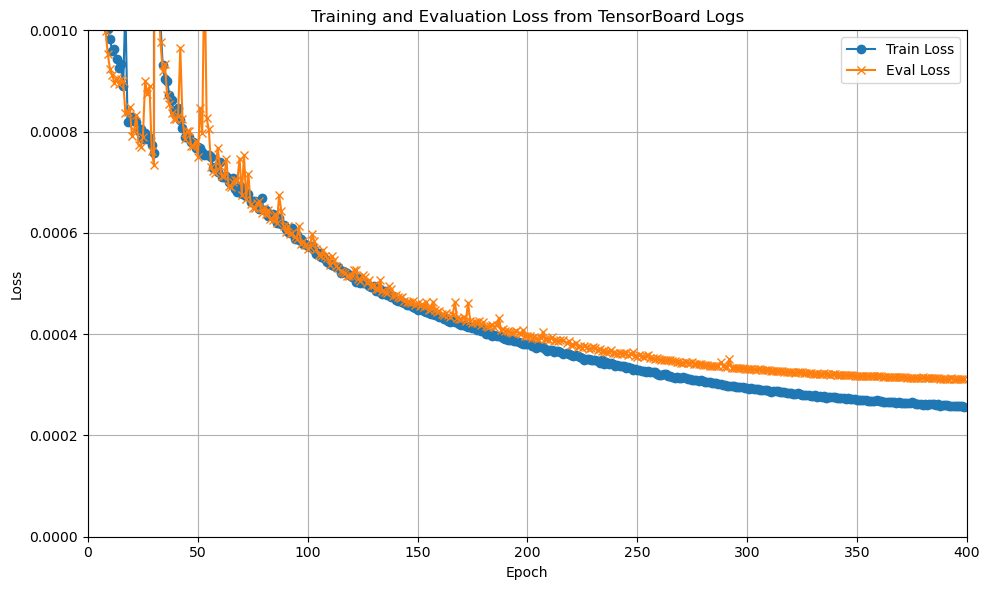

In [3]:
import os
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt

def arrays_from_tensorboard(run_name):
    # Path to your TensorBoard run directory (e.g., './runs/Jul13_13-21-57_my_run')
    #run_name = 'fmri_hcp_small_patch_resizelr_min20_hfmv_resume'
    log_dir = f'./save/{run_name}/tensorboard'
    
    # Load the TensorBoard event file
    ea = event_accumulator.EventAccumulator(log_dir,
        size_guidance={  # Load scalars, histograms, etc.
            event_accumulator.SCALARS: 0,
        })
    ea.Reload()
    
    # List available scalar tags
    print("Available scalar tags:", ea.Tags()['scalars'])
    
    # Change these if your tags are named differently
    train_loss_tag = 'train/loss'
    eval_loss_tag = 'test/loss'
    train_psnr_tag = 'train/psnr'
    eval_psnr_tag = 'test/psnr'
    
    # Extract data for each tag
    train_events = ea.Scalars(train_loss_tag)
    eval_events = ea.Scalars(eval_loss_tag)
    
    train_events_psnr = ea.Scalars(train_psnr_tag)
    eval_events_psnr = ea.Scalars(eval_psnr_tag)
    
    start_point = 0
    end_point = -1
    # Extract steps and values
    train_steps = [e.step for e in train_events][start_point:end_point]
    train_values = [e.value for e in train_events][start_point:end_point]
    
    eval_steps = [e.step for e in eval_events][start_point:end_point]
    eval_values = [e.value for e in eval_events][start_point:end_point]
    

    return [(train_steps, train_values),(eval_steps, eval_values)]

pre = arrays_from_tensorboard('fmri_hcp_medium_patch_propLT_min10_hfmv')
resume = arrays_from_tensorboard('fmri_hcp_medium_patch_propLT_min10_hfmv_resume')

train_steps = pre[0][0] + resume[0][0]
train_values = pre[0][1] + resume[0][1]
eval_steps = pre[1][0] + resume[1][0]
eval_values = pre[1][1] + resume[1][1]

'''
pre = arrays_from_tensorboard('fmri_hcp_medium_patch_propLT_min10_hfmv')

train_steps = pre[0][0] 
train_values = pre[0][1]
eval_steps = pre[1][0]
eval_values = pre[1][1]'''

plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_values, label='Train Loss', marker='o')
plt.plot(eval_steps, eval_values, label='Eval Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 0.001)
plt.xlim(0, 400)
plt.title('Training and Evaluation Loss from TensorBoard Logs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Available scalar tags: ['lr', 'train/loss', 'train/psnr', 'test/loss', 'test/psnr']
Available scalar tags: ['lr', 'train/loss', 'train/psnr', 'test/loss', 'test/psnr']
Available scalar tags: ['lr', 'train/loss', 'train/psnr', 'test/loss', 'test/psnr']


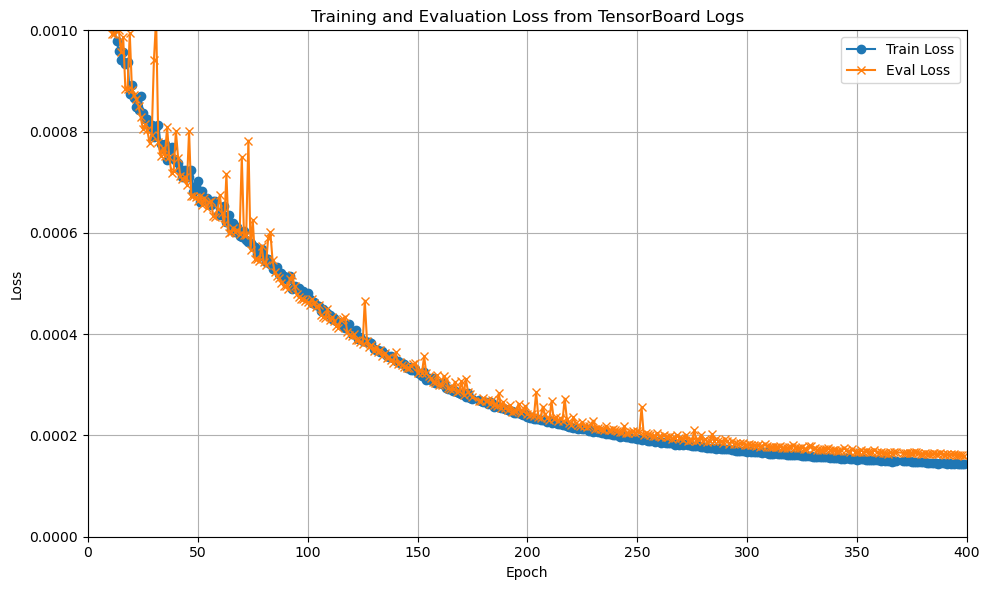

In [205]:
pre = arrays_from_tensorboard('fmri_hcp_small_patch_resizelr_min20_hfmv')
resume = arrays_from_tensorboard('fmri_hcp_small_patch_resizelr_min20_hfmv_resume')
resume2 = arrays_from_tensorboard('fmri_hcp_small_patch_resizelr_min20_hfmv_resume2')

train_steps = pre[0][0] + resume[0][0]+resume2[0][0]
train_values = pre[0][1] + resume[0][1]+resume2[0][1]
eval_steps = pre[1][0] + resume[1][0]+resume2[1][0]
eval_values = pre[1][1] + resume[1][1]+resume2[1][1]

'''
pre = arrays_from_tensorboard('fmri_hcp_medium_patch_propLT_min10_hfmv')

train_steps = pre[0][0] 
train_values = pre[0][1]
eval_steps = pre[1][0]
eval_values = pre[1][1]'''

plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_values, label='Train Loss', marker='o')
plt.plot(eval_steps, eval_values, label='Eval Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 0.001)
plt.xlim(0, 400)
plt.title('Training and Evaluation Loss from TensorBoard Logs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Available scalar tags: ['lr', 'train/loss', 'train/psnr', 'test/loss', 'test/psnr']
Available scalar tags: ['lr', 'train/loss', 'train/psnr', 'test/loss', 'test/psnr']
Available scalar tags: ['lr', 'train/loss', 'train/psnr', 'test/loss', 'test/psnr']
Available scalar tags: ['lr', 'train/loss', 'train/psnr', 'test/loss', 'test/psnr']
Available scalar tags: ['lr', 'train/loss', 'train/psnr', 'test/loss', 'test/psnr']


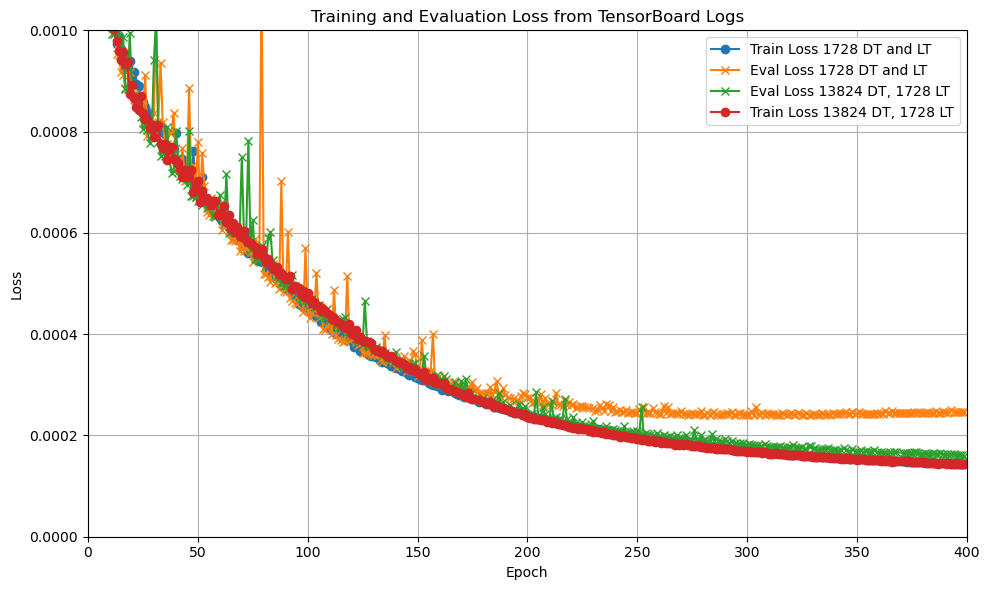

In [74]:
pre = arrays_from_tensorboard('fmri_hcp_medium_patch_propLT_min20_hfmv')
pre5 = arrays_from_tensorboard('fmri_hcp_medium_patch_propLT_min20_hfmv_resume')

train_steps = pre[0][0] +pre5[0][0] 
train_values = pre[0][1]+pre5[0][1]
eval_steps = pre[1][0] +pre5[1][0] 
eval_values = pre[1][1]+ pre5[1][1]


pre2 = arrays_from_tensorboard('fmri_hcp_small_patch_resizelr_min20_hfmv')
#pre3 = []
pre3 = arrays_from_tensorboard('fmri_hcp_small_patch_resizelr_min20_hfmv_resume')
pre4 = []
pre4 = arrays_from_tensorboard('fmri_hcp_small_patch_resizelr_min20_hfmv_resume2')

train_steps2 = pre2[0][0] +pre3[0][0] +pre4[0][0] 
train_values2 = pre2[0][1]+pre3[0][1]+pre4[0][1]
eval_steps2 = pre2[1][0] +pre3[1][0] +pre4[1][0] 
eval_values2 = pre2[1][1]+pre3[1][1]+pre4[1][1]

'''train_steps2 = pre2[0][0] 
train_values2 = pre2[0][1]
eval_steps2 = pre2[1][0]
eval_values2 = pre2[1][1]

pre = arrays_from_tensorboard('fmri_hcp_medium_patch_propLT_min10_hfmv')

train_steps = pre[0][0] 
train_values = pre[0][1]
eval_steps = pre[1][0]
eval_values = pre[1][1]'''

plt.figure(figsize=(10,6))
plt.plot(train_steps, train_values, label='Train Loss 1728 DT and LT', marker='o')
plt.plot(eval_steps, eval_values, label='Eval Loss 1728 DT and LT', marker='x')
plt.plot(eval_steps2, eval_values2, label='Eval Loss 13824 DT, 1728 LT', marker='x')
plt.plot(train_steps2, train_values2, label='Train Loss 13824 DT, 1728 LT', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 0.001)
plt.xlim(0, 400)
plt.title('Training and Evaluation Loss from TensorBoard Logs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import os
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt

# Path to your TensorBoard run directory (e.g., './runs/Jul13_13-21-57_my_run')
run_name = 'fmri_hcp_medium_patch_resizelr_min10_hfmv_lainr'
#run_name = 'imgrec_celeba_mamba_lainr_fourier_sr_allon'
#run_name2 = 'imgrec_cifar10_mamba_lainr_fourier_long_fast'
run_name2 = 'fmri_hcp_medium_patch_resizelr_min10_hfmv'

#run_name = 'imgrec_cifar10_mamba_lainr_fourier_const'
#run_name2 = 'imgrec_cifar10_lainr_fourier_const'

log_dir = f'./save/{run_name}/tensorboard'
log_dir2 = f'./save/{run_name2}/tensorboard'

# Load the TensorBoard event file
ea = event_accumulator.EventAccumulator(log_dir,
    size_guidance={  # Load scalars, histograms, etc.
        event_accumulator.SCALARS: 0,
    })

ea2 = event_accumulator.EventAccumulator(log_dir2,
    size_guidance={  # Load scalars, histograms, etc.
        event_accumulator.SCALARS: 0,
    })

ea.Reload()
ea2.Reload()

# List available scalar tags
print("Available scalar tags:", ea.Tags()['scalars'])

# Change these if your tags are named differently
train_loss_tag = 'train/psnr'
eval_loss_tag = 'train/psnr'
train_psnr_tag = 'train/psnr'
eval_psnr_tag = 'test/psnr'

# Extract data for each tag
train_events = ea.Scalars(eval_loss_tag)
eval_events = ea2.Scalars(eval_loss_tag)

train_events_psnr = ea.Scalars(eval_psnr_tag)
eval_events_psnr = ea2.Scalars(eval_psnr_tag)

start_point = 0
# Extract steps and values
train_steps = [e.step for e in train_events][start_point:]
train_values = [e.value for e in train_events][start_point:]

train_steps_psnr = [e.step for e in train_events_psnr][start_point:]
train_values_psnr = [e.value for e in train_events_psnr][start_point:]


eval_steps = [e.step for e in eval_events][start_point:]
eval_values = [e.value for e in eval_events][start_point:]

eval_steps_psnr = [e.step for e in eval_events_psnr][start_point:]
eval_values_psnr = [e.value for e in eval_events_psnr][start_point:]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_values, label='MambaINR Train Loss', marker='o')
plt.plot(eval_steps, eval_values, label='MambaINR + Bias Train Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.ylim(0, 0.0002)
plt.title('MambaINR PSNR with and without Cross Attention Bias')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(train_steps_psnr, train_values_psnr, label='Mamba Eval PSNR', marker='o')
plt.plot(eval_steps_psnr, eval_values_psnr, label='Transformer Eval PSNR', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.ylim(0, 0.0002)
plt.title('Training and Evaluation PSNR from TensorBoard Logs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


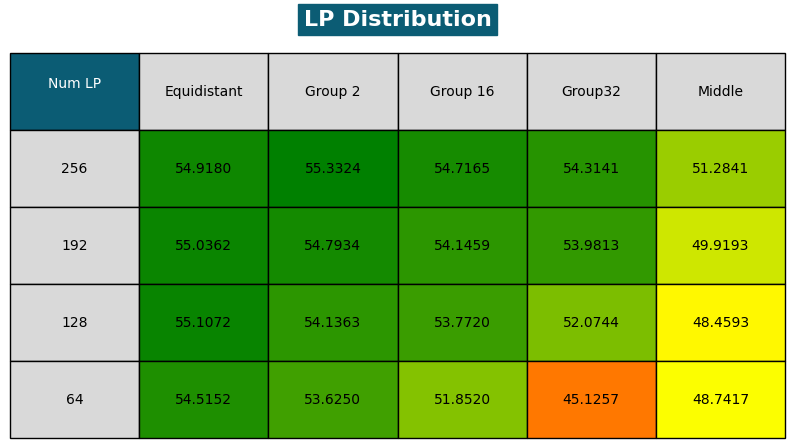

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.table import Table
from matplotlib.colors import LinearSegmentedColormap

# Define data and labels
row_labels = ['256', '192', '128', '64']
col_labels = ['Equidistant', 'Group 2', 'Group 16', 'Group32', 'Middle']

data = np.array([
    [54.9180, 55.3324, 54.7165, 54.3141, 51.2841],
    [55.0362, 54.7934, 54.1459, 53.9813, 49.9193],
    [55.1072, 54.1363, 53.7720, 52.0744, 48.4593],
    [54.5152, 53.6250, 51.8520, 45.1257, 48.7417]
])

# Normalize for color mapping
vmin = 42
vmax = data.max()
norm = plt.Normalize(vmin, vmax)

# Green → Yellow → Red colormap
cmap = LinearSegmentedColormap.from_list("value_cmap", ["red", "yellow", "green"])

# Plot setup
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_axis_off()

table = Table(ax, bbox=[0, 0, 1, 1])

n_rows, n_cols = data.shape
width, height = 1.0 / (n_cols + 1), 1.0 / (n_rows + 1)

# Add data cells with individual background colors based on value
for i in range(n_rows):
    for j in range(n_cols):
        val = data[i, j]
        bgcolor = cmap(norm(val))  # use value to get color
        cell = table.add_cell(i + 1, j + 1, width, height, text=f"{val:.4f}", loc='center',
                              facecolor=bgcolor, edgecolor='black')
        cell.set_linewidth(1)

# Row labels
for i, label in enumerate(row_labels):
    table.add_cell(i + 1, 0, width, height, text=label, loc='center',
                   facecolor='#d9d9d9', edgecolor='black')

# Column labels
for j, label in enumerate(col_labels):
    table.add_cell(0, j + 1, width, height, text=label, loc='center',
                   facecolor='#d9d9d9', edgecolor='black')

# Top-left corner cell
cell = table.add_cell(0, 0, width, height, text='Num LP\n', loc='center', facecolor='#0b5c74', edgecolor='black')
cell.get_text().set_color('white')

# Add table to plot
ax.add_table(table)

# Title
ax.set_title("LP Distribution", fontsize=16, fontweight='bold', color='white',
             backgroundcolor='#0b5c74', pad=20)

plt.show()
